In [1]:
!pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.8/265.8 MB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.46.0.6-py2.py3-none-any.whl size=265859786 sha256=cc33fd580673fa820e78fa432e53632b28e4f90c1b75fbdf4966eb0117a89a38
  Stored in directory: /root/.cache/pip/wheels/0c/95/eb/b449c73f478dbc4557b80170cf7f2aa6db15862877e9a63536
Successfully built h2o


In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
import h2o
from h2o.estimators import H2OGradientBoostingEstimator
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
import joblib



# **Data Preprocess**

In [3]:
small_TAs = 'new_therapy_area_' + pd.Index(
  'Endocrinology|Bone|Hepatic diseases|Infectious Diseases|Hematology|Ophthalmology'.split('|')
)
df = pd.read_csv('Data/rollup_df_1123_seq_final.txt', sep='|').query('pair_trial_seq <= 8').pipe(
    lambda df: df.assign(
      new_therapy_area_Other=df[
          small_TAs.to_list() + ['new_therapy_area_Other']
      ].max(1)
    ).drop(
      columns=small_TAs
    )
)

df.pipe(
    lambda df: df.assign(TA=df[[
        'new_therapy_area_Autoimmune',
        'new_therapy_area_Cardiovascular', 'new_therapy_area_Dermatology',
        # 'new_therapy_area_Bone', 'new_therapy_area_Endocrinology', 'new_therapy_area_Hepatic diseases', 'new_therapy_area_Infectious Diseases',
        # 'new_therapy_area_Hematology', 'new_therapy_area_Ophthalmology',
        'new_therapy_area_Gastrointestinal',
        'new_therapy_area_Genetic and Rare Diseases',
        'new_therapy_area_Infections (bacterial)',
        'new_therapy_area_Infections (viral)',
        'new_therapy_area_Metabolic disorders', 'new_therapy_area_Neurology',
        'new_therapy_area_Neuroscience (non-progressive)',
        'new_therapy_area_Oncology',
        'new_therapy_area_Other', 'new_therapy_area_Pain',
        'new_therapy_area_Progressive neurological disorders',
        'new_therapy_area_Psychiatry and Mental Health',
        'new_therapy_area_Respiratory', 'new_therapy_area_Rheumatology',
        'new_therapy_area_Urology and Reproductive Health'
    ]].idxmax(axis=1).str[17:])
)[['trial_drug_cleaned', 'TA']].drop_duplicates().TA.value_counts()

df.rename(columns={'LLM_GBT_4o_Human_Importance_Ratings': 'LLM_GPT_4o_Human_Importance_Ratings'}, inplace=True)
df['avg_days_since_first_start'] = df['days_since_first_start'] / df['pair_trial_seq']

unique_drugs = df.pipe(
    lambda df: df.assign(TA=df[[
        'new_therapy_area_Autoimmune',
        'new_therapy_area_Cardiovascular', 'new_therapy_area_Dermatology',
        # 'new_therapy_area_Bone', 'new_therapy_area_Endocrinology', 'new_therapy_area_Hepatic diseases', 'new_therapy_area_Infectious Diseases',
        # 'new_therapy_area_Hematology', 'new_therapy_area_Ophthalmology',
        'new_therapy_area_Gastrointestinal',
        'new_therapy_area_Genetic and Rare Diseases',
        'new_therapy_area_Infections (bacterial)',
        'new_therapy_area_Infections (viral)',
        'new_therapy_area_Metabolic disorders', 'new_therapy_area_Neurology',
        'new_therapy_area_Neuroscience (non-progressive)',
        'new_therapy_area_Oncology',
        'new_therapy_area_Other', 'new_therapy_area_Pain',
        'new_therapy_area_Progressive neurological disorders',
        'new_therapy_area_Psychiatry and Mental Health',
        'new_therapy_area_Respiratory', 'new_therapy_area_Rheumatology',
        'new_therapy_area_Urology and Reproductive Health'
    ]].idxmax(axis=1).str[17:])
).groupby('trial_drug_cleaned').TA.apply(lambda x: x.value_counts().index[0]).reset_index()
pd.set_option('display.max_columns', None)

features = [col for col in df.columns if col not in ['trial_drug_cleaned', 'drug_outcome', 'disease_type', 'drug_status', 'Unnamed: 0', 'nct_id', 'pcd']]
target = 'drug_outcome'

# Split the unique drugs into train, test, and validation sets
train_drugs, test_val_drugs = train_test_split(
    unique_drugs, test_size=0.3, stratify=unique_drugs['TA'], random_state=42
)
test_drugs, val_drugs = train_test_split(
    test_val_drugs, test_size=0.5, stratify=test_val_drugs['TA'], random_state=42
)

# Create train, test, and validation DataFrames
train_df = df[df['trial_drug_cleaned'].isin(train_drugs["trial_drug_cleaned"])]
test_df = df[df['trial_drug_cleaned'].isin(test_drugs["trial_drug_cleaned"])]
val_df = df[df['trial_drug_cleaned'].isin(val_drugs["trial_drug_cleaned"])]

# Separate features and target for each dataset
X_train, y_train = train_df[features], train_df[target]
X_test, y_test = test_df[features], test_df[target]
X_val, y_val = val_df[features], val_df[target]




# **Random Forest**

Best Hyperparameters: {'n_estimators': 1220, 'max_depth': 15, 'max_features': 'sqrt'}
Best Validation AUC Score: 0.849


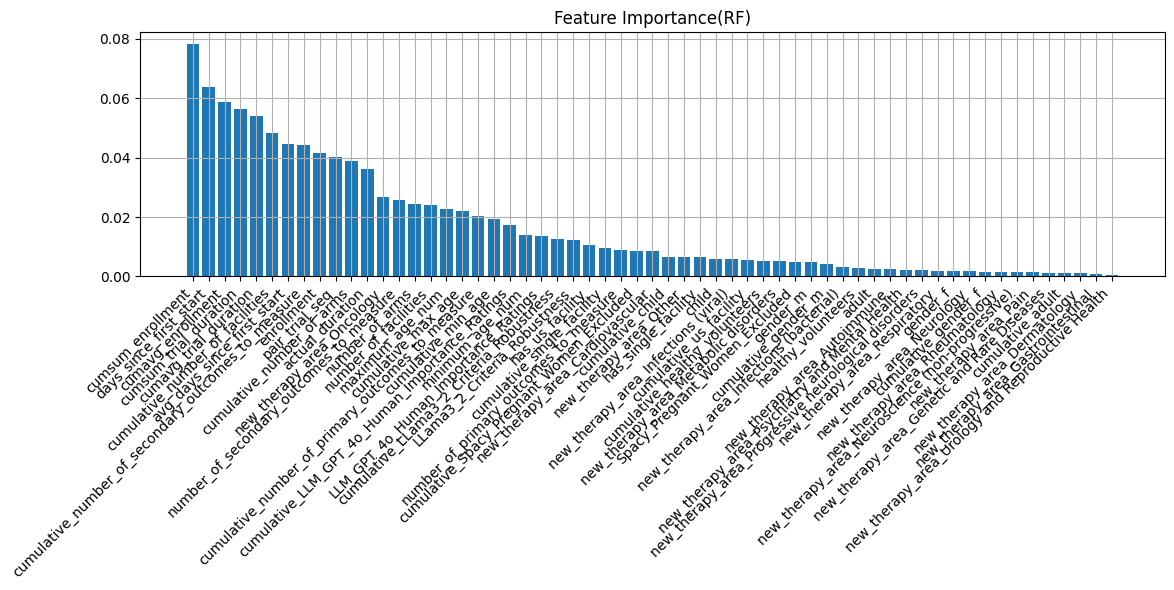


Final AUC Score on Test Set: 0.802


In [4]:
model = RandomForestClassifier(random_state=42)


best_val_auc_rf = 0
best_params_rf = {}

# Loop over the possible parameter combinations
for n_estimators in list(range(1200, 1600, 10)):
    for max_depth in list(range(10, 26, 1)):
        # Create and fit the RandomForest model with current hyperparameters
        model.set_params(n_estimators=n_estimators, max_depth=max_depth, max_features='sqrt')
        model.fit(X_train, y_train)

        # Predict probabilities on the test set
        test_prob = model.predict_proba(X_val)[:, 1]

        # Calculate the ROC AUC score
        auc_score_rf = roc_auc_score(y_val, test_prob)

        # Track the best hyperparameters and AUC score
        if auc_score_rf > best_val_auc_rf:
            best_val_auc_rf = auc_score_rf
            best_params_rf = {
                'n_estimators': n_estimators,
                'max_depth': max_depth,
                'max_features': 'sqrt'
            }

# Print the best parameters and AUC score
print(f"Best Hyperparameters: {best_params_rf}")
print(f"Best Validation AUC Score: {best_val_auc_rf:.3f}")

# Train the model with the best parameters
best_model_rf = RandomForestClassifier(
    n_estimators=best_params_rf['n_estimators'],
    max_depth=best_params_rf['max_depth'],
    max_features=best_params_rf['max_features'],
    random_state=42
)
best_model_rf.fit(X_train, y_train)


# Get feature importances from the best model
importances = best_model_rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.title('Feature Importance(RF)')
plt.bar(range(len(X_train.columns)), importances[indices])
plt.xticks(range(len(X_train.columns)), [X_train.columns[i] for i in indices], rotation=45, ha='right')
plt.tight_layout()
plt.grid(True)  # Adding grid to the plot
plt.show()

# Optional: To predict the probabilities on the test set
test_prob = best_model_rf.predict_proba(X_test)[:, 1]
auc_score_rf = roc_auc_score(y_test, test_prob)
print(f"\nFinal AUC Score on Test Set: {auc_score_rf:.3f}")

# **XGBoost**


Best Parameters: {'max_depth': 5, 'learning_rate': 0.039999999999999994, 'min_child_weight': 9, 'seed': 42}
Best Validation AUC: 0.861443173943174
Test AUC Score: 0.7902800286435758


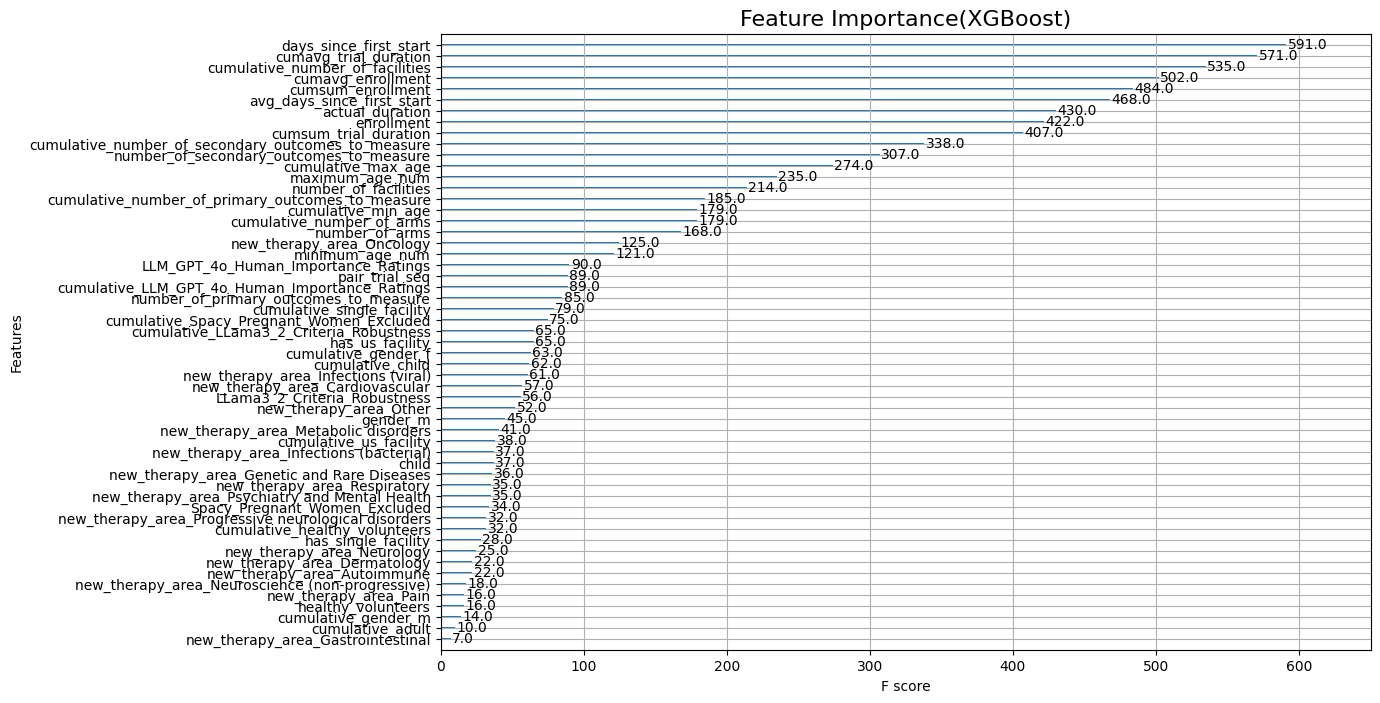

In [5]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
dval = xgb.DMatrix(X_val, label=y_val)
evals = [(dtrain, 'train'), (dval, 'validation')]


best_val_auc_xgb = 0
best_params_xgb = None
params = {}

for max_depth in range(3, 10):  # Depth of the tree
    for learning_rate in np.linspace(0.01, 0.30, 30):  # Step size
        for min_child_weight in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:  # Minimum sum of instance weights
            params['max_depth'] = max_depth
            params['learning_rate'] = learning_rate
            params['min_child_weight'] = min_child_weight
            params['seed'] = 42
            model = xgb.train(
                params,
                dtrain,
                num_boost_round=1000,
                evals=evals,
                early_stopping_rounds=50,
                verbose_eval=False
            )

            y_val_pred_prob = model.predict(dval)
            auc = roc_auc_score(y_val, y_val_pred_prob)

            if auc > best_val_auc_xgb:
                best_val_auc_xgb = auc
                best_params_xgb = params.copy()

print("\nBest Parameters:", best_params_xgb)
print("Best Validation AUC:", best_val_auc_xgb)

best_model_xgb = xgb.train(best_params_xgb, dtrain, num_boost_round=1000, evals=evals, early_stopping_rounds=50,  verbose_eval=False)

y_pred_prob = best_model_xgb.predict(dtest)
auc_score_xgb = roc_auc_score(y_test, y_pred_prob)
print("Test AUC Score:", auc_score_xgb)

fig, ax = plt.subplots(figsize=(12, 8))
xgb.plot_importance(best_model_xgb, importance_type='weight', ax=ax)
plt.title("Feature Importance(XGBoost)", fontsize=16)
plt.show()

# **LightGBM**


Best Parameters: {'objective': 'binary', 'metric': 'binary_logloss', 'boosting_type': 'gbdt', 'num_leaves': 33, 'learning_rate': 0.29, 'max_depth': 8, 'seed': 42, 'verbose': -1}
Best Validation AUC: 0.872693607068607

Test AUC Score: 0.8087


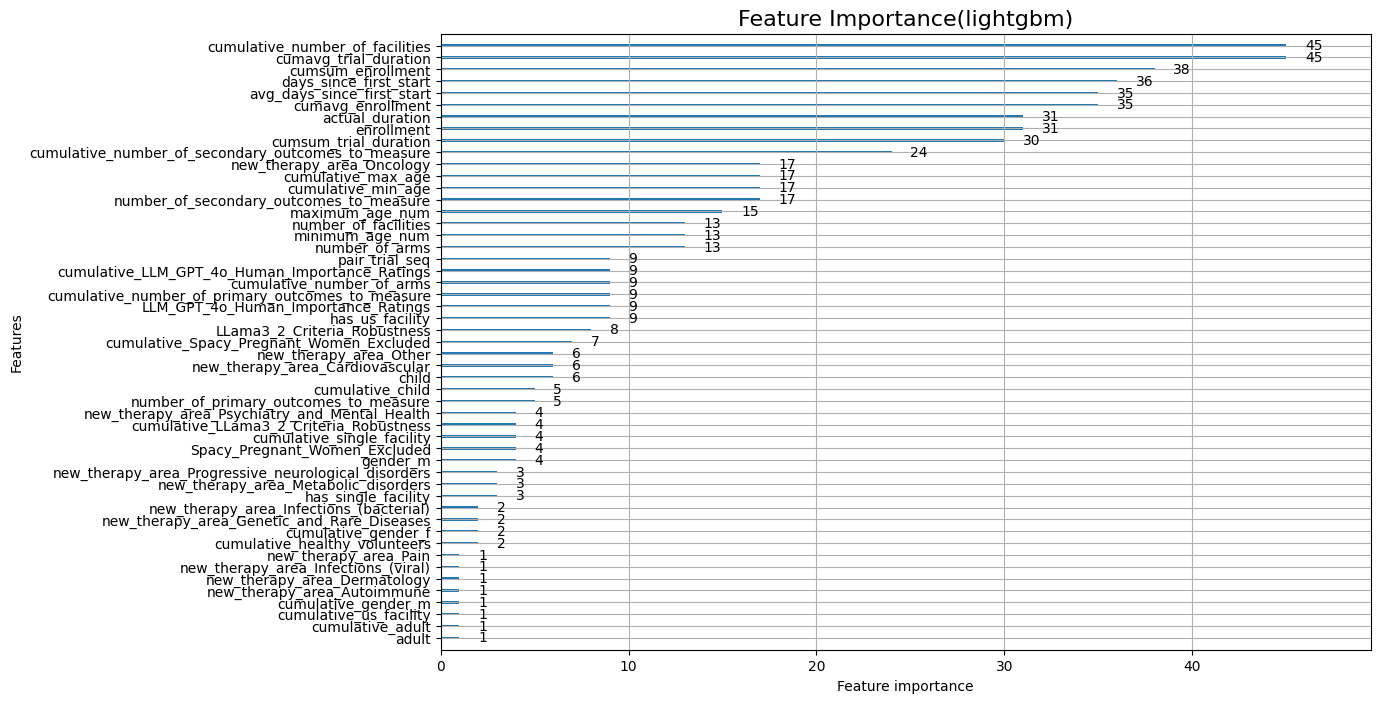

In [6]:
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

callbacks = [
    lgb.early_stopping(stopping_rounds=50, verbose=False)
]

best_val_auc_lgb = 0
best_params_lgb = {}

# Nested loops for grid search
for num_leaves in list(range(20, 40, 1)):
    for learning_rate in np.linspace(0.01, 0.3, 30):
        for max_depth in [5, 6, 7, 8, 9, 10]:  # Adding different values for max_depth
            # Current parameter configuration
            params = {
                'objective': 'binary',
                'metric': 'binary_logloss',
                'boosting_type': 'gbdt',
                'num_leaves': num_leaves,
                'learning_rate': learning_rate,
                'max_depth': max_depth,  # Adding max_depth to the parameters
                'seed': 42,
                'verbose': -1
            }

            # Train model with early stopping
            model = lgb.train(
                params,
                train_data,
                num_boost_round=1000,
                valid_sets=[train_data, valid_data],
                callbacks=callbacks
            )

            # Validate and track best parameters
            y_pred_prob = model.predict(X_val, num_iteration=model.best_iteration)
            val_auc = roc_auc_score(y_val, y_pred_prob)

            if val_auc > best_val_auc_lgb:
                best_val_auc_lgb = val_auc
                best_params_lgb = params.copy()

print("\nBest Parameters:", best_params_lgb)
print("Best Validation AUC:", best_val_auc_lgb)

# Retrain the model with the best parameters
best_model_lgb = lgb.train(
    best_params_lgb,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, valid_data],
    callbacks=callbacks
)

# Predict on the test set and calculate AUC
y_pred_prob = best_model_lgb.predict(X_test, num_iteration=best_model_lgb.best_iteration)
auc_score_lgb = roc_auc_score(y_test, y_pred_prob)
print(f"\nTest AUC Score: {auc_score_lgb:.4f}")

# Plot feature importance
fig, ax = plt.subplots(figsize=(12, 8))
lgb.plot_importance(best_model_lgb, ax=ax)
plt.title("Feature Importance(lightgbm)", fontsize=16)
plt.show()

# **h2oGBM**


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.25" 2024-10-15; OpenJDK Runtime Environment (build 11.0.25+9-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.25+9-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpbtfuet1o
  JVM stdout: /tmp/tmpbtfuet1o/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpbtfuet1o/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,29 days
H2O_cluster_name:,H2O_from_python_unknownUser_b0xptu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"



Best Parameters: {'ntrees': 120, 'max_depth': 8, 'learn_rate': 0.195, 'stopping_metric': 'AUC', 'seed': 42, 'stopping_rounds': 50}
Best Validation AUC: 0.8439286642411642


/usr/local/lib/python3.10/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: early stopping is enabled but neither score_tree_interval or score_each_iteration are defined. Early stopping will not be reproducible!
  warnings.warn(mesg["message"], RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"



Best Model Test AUC: 0.809

Top 10 Most Important Features:
                                          variable  relative_importance  scaled_importance  percentage
                                 cumsum_enrollment           290.577881           1.000000    0.146970
                             cumavg_trial_duration           126.846275           0.436531    0.064157
                            days_since_first_start           120.843369           0.415873    0.061121
                   cumulative_number_of_facilities           120.768623           0.415615    0.061083
                             cumsum_trial_duration           111.156693           0.382537    0.056222
                        avg_days_since_first_start            93.878593           0.323075    0.047483
                         new_therapy_area_Oncology            93.561340           0.321984    0.047322
                                 cumavg_enrollment            69.845535           0.240368    0.035327
            

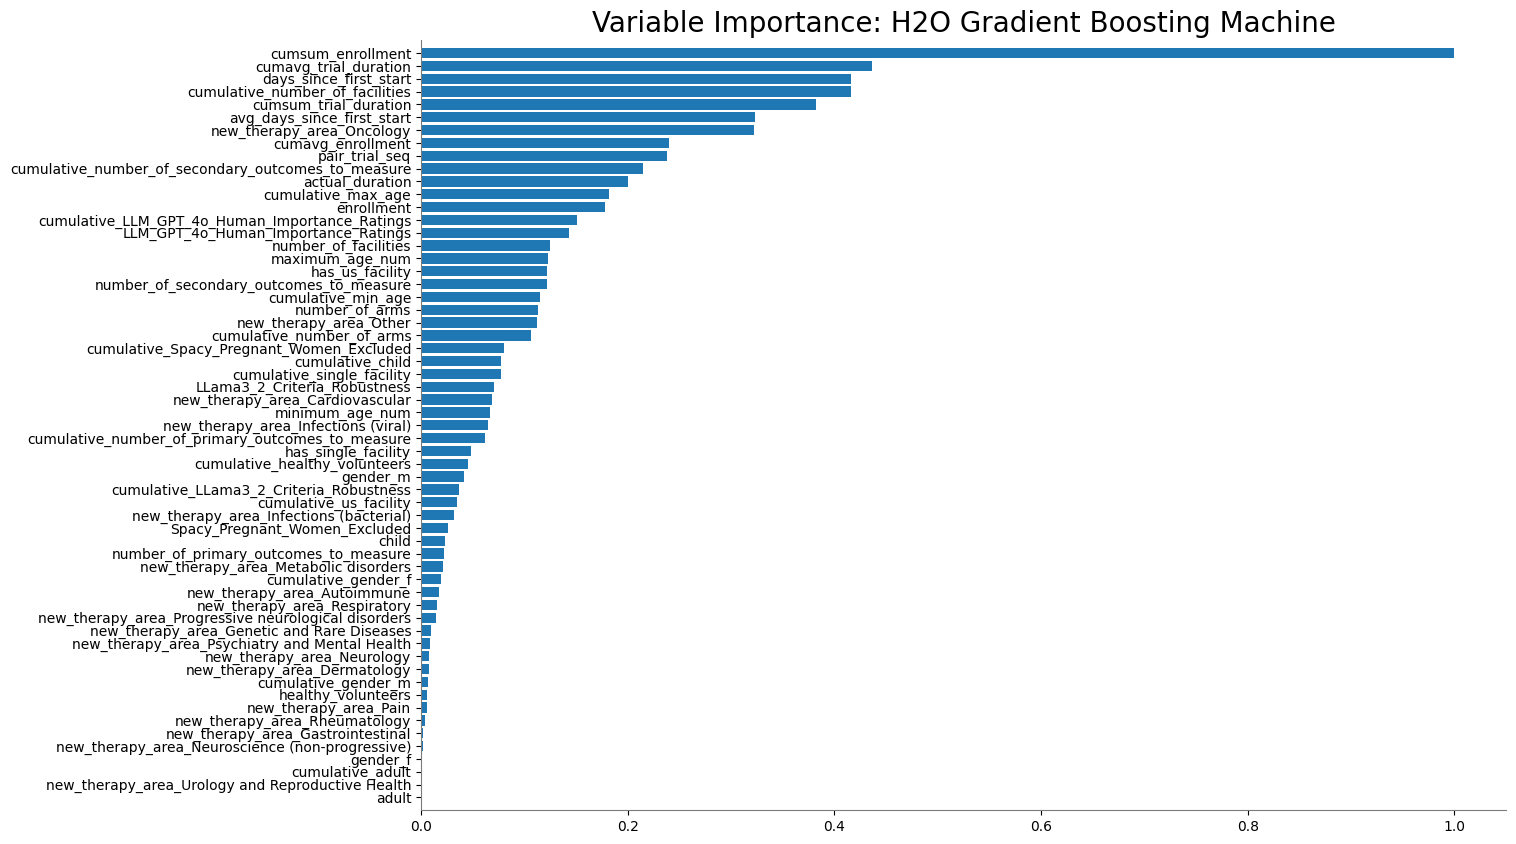

H2O session _sid_a186 closed.


<ipython-input-7-87a4c3d63ed6>:90: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown(prompt=False)


<Figure size 640x480 with 0 Axes>

In [7]:
# Initialize H2O
h2o.init()
h2o.no_progress()

# Convert to H2OFrames
train_h2o = h2o.H2OFrame(train_df)
test_h2o = h2o.H2OFrame(test_df)
val_h2o = h2o.H2OFrame(val_df)

# Ensure target is categorical
train_h2o[target] = train_h2o[target].asfactor()
test_h2o[target] = test_h2o[target].asfactor()
val_h2o[target] = val_h2o[target].asfactor()

# Comprehensive hyperparameter grid
# Prepare to store results
results = []
best_val_auc_h2o = 0
best_params_h2o = {}
# Nested loops to iterate through all hyperparameter combinations
for ntrees in list(range(120, 200, 1)):
    for max_depth in [8, 9, 10, 11, 12]:
        for learn_rate in [0.195, 0.2, 0.205]:
            # Initialize the GBM model with specific parameters

            params = {
                'ntrees': ntrees,
                'max_depth': max_depth,
                'learn_rate': learn_rate,
                'stopping_metric': 'AUC',  # Adding max_depth to the parameters
                'seed': 42,
                'stopping_rounds': 50
            }
            gbm = H2OGradientBoostingEstimator(params)

            # Train the model
            gbm.train(
                x=features,
                y=target,
                training_frame=train_h2o,
                validation_frame=val_h2o
            )

            # Get validation AUC
            val_auc = gbm.auc(valid=True)

            # Store results
            if val_auc > best_val_auc_h2o:
                best_val_auc_h2o = val_auc
                best_params_h2o = params.copy()

print("\nBest Parameters:", best_params_h2o)
print("Best Validation AUC:", best_val_auc_h2o)

# Retrain the best model
best_model_h2o = H2OGradientBoostingEstimator(
    ntrees=int(best_params_h2o ['ntrees']),
    max_depth=int(best_params_h2o ['max_depth']),
    learn_rate=best_params_h2o ['learn_rate'],
    seed=42,
    stopping_metric='AUC',
    stopping_tolerance=0.001,
    stopping_rounds=50
)

best_model_h2o.train(
    x=features,
    y=target,
    training_frame=train_h2o,
    validation_frame=val_h2o
)

# Make predictions on test set
predictions = best_model_h2o.predict(test_h2o)
pred_prob = predictions.as_data_frame()['p1']

# Calculate test AUC
auc_score_h2o = roc_auc_score(test_df[target], pred_prob)
print(f"\nBest Model Test AUC: {auc_score_h2o:.3f}")

# Feature importance
feature_importance = best_model_h2o.varimp(use_pandas=True)
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Visualize feature importance
best_model_h2o.varimp_plot(len(features))

# Shutdown H2O
h2o.shutdown(prompt=False)

# **Final Model**

In [8]:
models_data = [
    {
        'model': 'H2O GBM',
        'best_val_auc': best_val_auc_h2o,
        'test_auc': auc_score_h2o,
        'best_params': best_params_h2o

    },
    {
        'model': 'LightGBM',
        'best_val_auc': best_val_auc_lgb,
        'test_auc': auc_score_lgb,
        'best_params': best_params_lgb

    },
    {
        'model': 'XGBoost',
        'best_val_auc': best_val_auc_xgb,
        'test_auc': auc_score_xgb,
        'best_params': best_params_xgb

    },
    {
        'model': 'Random Forest',
        'best_val_auc': best_val_auc_rf,
        'test_auc': auc_score_rf,
        'best_params': best_params_rf

    }
]

# Create a DataFrame
results_df = pd.DataFrame(models_data)

# Sort by 'best_val_auc' in descending order
results_df = results_df.sort_values(by='best_val_auc', ascending=False).reset_index(drop=True)

# Display the DataFrame
print(results_df)

           model  best_val_auc  test_auc  \
0       LightGBM      0.872694  0.808724   
1        XGBoost      0.861443  0.790280   
2  Random Forest      0.848579  0.801690   
3        H2O GBM      0.843929  0.808842   

                                         best_params  
0  {'objective': 'binary', 'metric': 'binary_logl...  
1  {'max_depth': 5, 'learning_rate': 0.0399999999...  
2  {'n_estimators': 1220, 'max_depth': 15, 'max_f...  
3  {'ntrees': 120, 'max_depth': 8, 'learn_rate': ...  


# **Final lightGBM**

/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:341: UserWarning: Only training set found, disabling early stopping.
  _log_warning("Only training set found, disabling early stopping.")



Final Test AUC Score: 0.7916
Final Test Accuracy: 0.7163


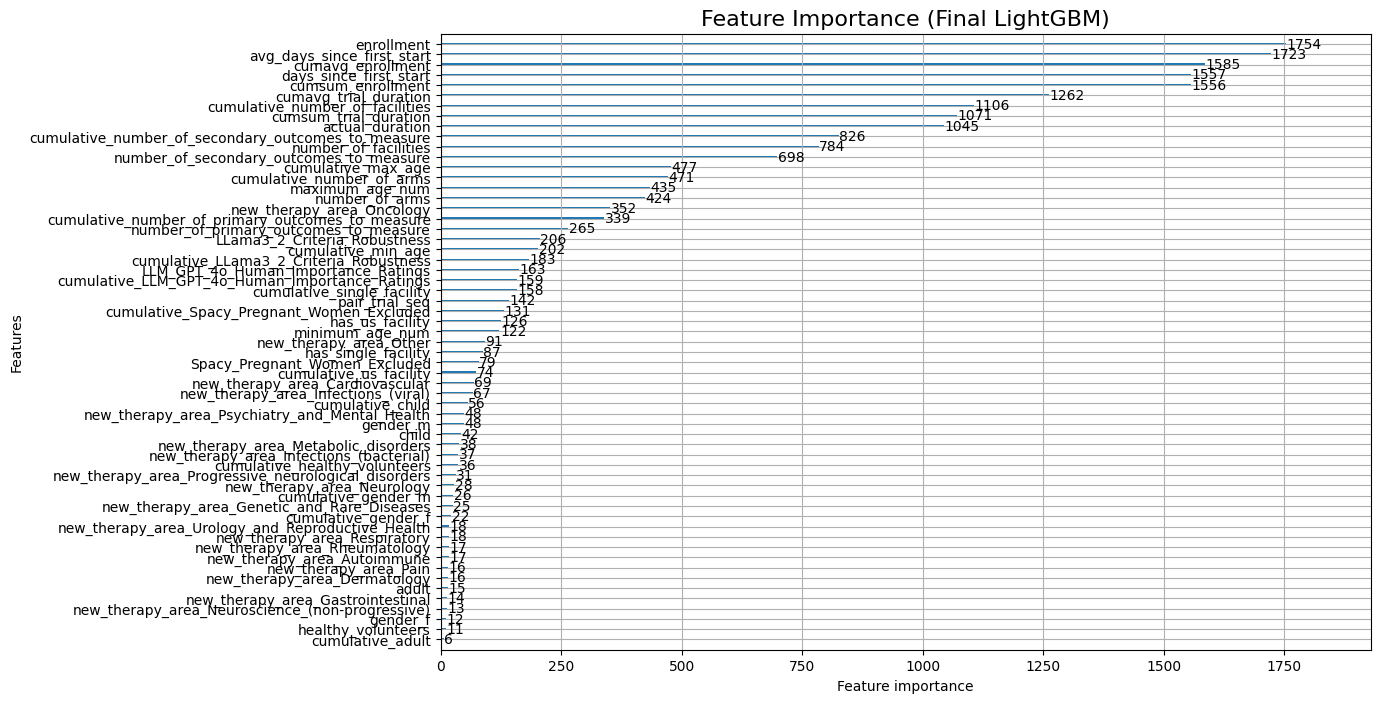

In [9]:
X_train_combined = pd.concat([X_train, X_val], axis=0)
y_train_combined = pd.concat([y_train, y_val], axis=0)

# Create a new LightGBM dataset for the combined data
train_combined_data = lgb.Dataset(X_train_combined, label=y_train_combined)

# Retrain the model using the best parameters on the combined dataset
final_model_lgb = lgb.train(
    best_params_lgb,
    train_combined_data,
    num_boost_round=1000,
    valid_sets=[train_combined_data],
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
)

# Predict on the test set and calculate AUC
y_pred_prob_final = final_model_lgb.predict(X_test, num_iteration=final_model_lgb.best_iteration)
y_pred_final = (y_pred_prob_final >= 0.5).astype(int)
final_auc_score_lgb = roc_auc_score(y_test, y_pred_prob_final)
print(f"\nFinal Test AUC Score: {final_auc_score_lgb:.4f}")
final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"Final Test Accuracy: {final_accuracy:.4f}")

# Plot feature importance
fig, ax = plt.subplots(figsize=(12, 8))
lgb.plot_importance(final_model_lgb, ax=ax)
plt.title("Feature Importance (Final LightGBM)", fontsize=16)
plt.show()

# **Feature Importance**

<ipython-input-10-c20ab101af73>:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '51.66926956176758' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  feature_importances.loc[feature, 'h2o'] = h2o_importance.loc[feature, 'relative_importance']


Top 10 Features Based on Averaged Importance Across Models:
                                                    average_importance
cumsum_enrollment                                             0.086357
cumavg_trial_duration                                         0.065096
days_since_first_start                                        0.063698
cumulative_number_of_facilities                               0.061806
cumavg_enrollment                                             0.052841
cumsum_trial_duration                                         0.052628
avg_days_since_first_start                                    0.051333
enrollment                                                    0.042213
actual_duration                                               0.041967
cumulative_number_of_secondary_outcomes_to_measure            0.038899


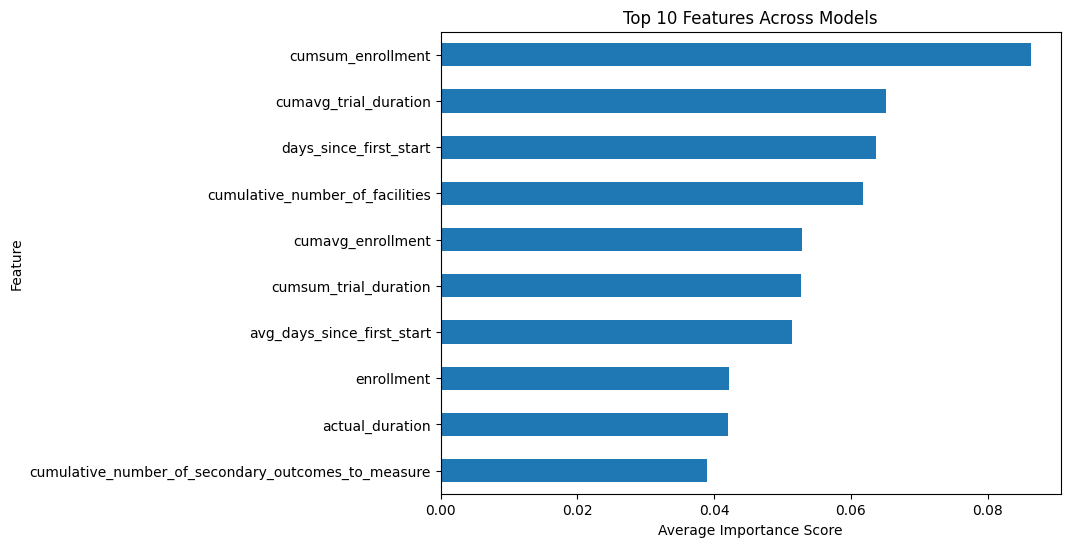

In [10]:
feature_names = X_train.columns.tolist()

feature_importances = pd.DataFrame(0, index=feature_names, columns=['h2o', 'lgb', 'xgb', 'rf'])

# H2O feature importance
h2o_importance = best_model_h2o.varimp(use_pandas=True)
h2o_importance.set_index('variable', inplace=True)
for feature in feature_names:
    if feature in h2o_importance.index:
        feature_importances.loc[feature, 'h2o'] = h2o_importance.loc[feature, 'relative_importance']

# LightGBM feature importance
lgb_importance = best_model_lgb.feature_importance(importance_type='split')  # Use the `split` type for counts
feature_importances['lgb'] = lgb_importance

# XGBoost feature importance
xgb_importance = best_model_xgb.get_score(importance_type='weight')
for feature, score in xgb_importance.items():
    if feature in feature_names:
        feature_importances.loc[feature, 'xgb'] = score

# Random Forest feature importance
rf_importance = best_model_rf.feature_importances_
feature_importances['rf'] = rf_importance

# Normalize the importance scores for each model
feature_importances = feature_importances.div(feature_importances.sum(axis=0), axis=1)

# Calculate the average importance score across models
feature_importances['average_importance'] = feature_importances.mean(axis=1)

# Rank features by average importance
feature_importances = feature_importances.sort_values(by='average_importance', ascending=False)

# Extract the top 10 most important features
top_10_features = feature_importances.head(10)

# Display results
print("Top 10 Features Based on Averaged Importance Across Models:")
print(top_10_features[['average_importance']])

# Optional: Plot the top 10 features
import matplotlib.pyplot as plt

top_10_features[['average_importance']].plot(kind='barh', legend=False, figsize=(8, 6))
plt.xlabel("Average Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Features Across Models")
plt.gca().invert_yaxis()  # Reverse the order for better readability
plt.show()

# **Logistic Regression with L2 (Ridge) Regularization**

<ipython-input-11-75a1759e6003>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[numerical_cols] = imputer.fit_transform(X_train[numerical_cols])
<ipython-input-11-75a1759e6003>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numerical_cols] = imputer.transform(X_test[numerical_cols])
<ipython-input-11-75a1759e6003>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

Best Hyperparameters: {'C': 0.04520353656360243}
Best Validation AUC Score: 0.753


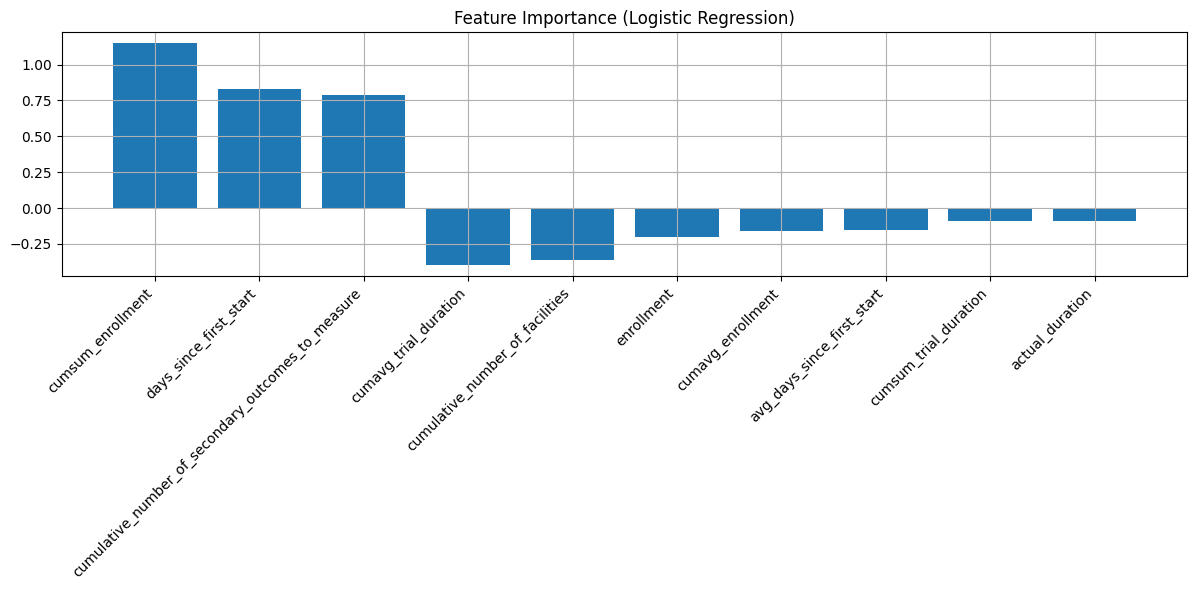


Final AUC Score on Test Set: 0.702


In [11]:

numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns

# Initialize the SimpleImputer with median strategy
imputer = SimpleImputer(strategy='median')

# Fit the imputer on the training data only
X_train[numerical_cols] = imputer.fit_transform(X_train[numerical_cols])

# Apply the trained imputer to test and validation data
X_test[numerical_cols] = imputer.transform(X_test[numerical_cols])
X_val[numerical_cols] = imputer.transform(X_val[numerical_cols])


X_train_top10 = X_train[top_10_features.index.tolist()]
X_val_top10 = X_val[top_10_features.index.tolist()]
X_test_top10 = X_test[top_10_features.index.tolist()]

scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler.fit_transform(X_train_top10)
X_val_scaled = scaler.transform(X_val_top10)
X_test_scaled = scaler.transform(X_test_top10)

best_val_auc_lr = 0
best_params_lr = {}
Cs = np.logspace(-3, 3, 30)  # Range of regularization strengths

for C in Cs:
    try:
        model = LogisticRegression(
            penalty='l2',  # Ridge regularization
            C=C,
            solver='liblinear',  # Supports l2 penalty
            random_state=42,
            max_iter=5000  # Increase max iterations
        )
        model.fit(X_train_scaled, y_train)

        val_prob = model.predict_proba(X_val_scaled)[:, 1]
        auc_score_lr = roc_auc_score(y_val, val_prob)

        if auc_score_lr > best_val_auc_lr:
            best_val_auc_lr = auc_score_lr
            best_params_lr = {'C': C}
    except Exception as e:
        print(f"Skipping C={C} due to error: {e}")

print(f"Best Hyperparameters: {best_params_lr}")
print(f"Best Validation AUC Score: {best_val_auc_lr:.3f}")

best_model_lr = LogisticRegression(
    penalty='l2',
    C=best_params_lr['C'],
    solver='liblinear',
    random_state=42,
    max_iter=5000
)
best_model_lr.fit(X_train_scaled, y_train)

# Get coefficients and plot feature importance
coef = best_model_lr.coef_[0]
indices = np.argsort(np.abs(coef))[::-1]

plt.figure(figsize=(12, 6))
plt.title('Feature Importance (Logistic Regression)')
plt.bar(range(len(X_train_top10.columns)), coef[indices])
plt.xticks(range(len(X_train_top10.columns)), [X_train_top10.columns[i] for i in indices], rotation=45, ha='right')
plt.tight_layout()
plt.grid(True)
plt.show()

# Evaluate on test set
test_prob = best_model_lr.predict_proba(X_test_scaled)[:, 1]
auc_score_lr_test = roc_auc_score(y_test, test_prob)
print(f"\nFinal AUC Score on Test Set: {auc_score_lr_test:.3f}")

# **Logistic regression final model**

In [16]:
X_train_val_combined = np.vstack([X_train_scaled, X_val_scaled])
y_train_val_combined = np.concatenate([y_train, y_val])

# Fit the final logistic regression model on the combined dataset
final_model_lr = LogisticRegression(
    penalty='l2',
    C=best_params_lr['C'],
    solver='liblinear',
    random_state=42,
    max_iter=5000
)

final_model_lr.fit(X_train_val_combined, y_train_val_combined)

# Evaluate on the test set
test_prob = final_model_lr.predict_proba(X_test_scaled)[:, 1]
auc_score_lr_test = roc_auc_score(y_test, test_prob)

print(f"\nFinal AUC Score on Test Set after combining Train and Validation Data: {auc_score_lr_test:.3f}")

test_pred_combined = final_model_lr.predict(X_test_scaled)

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, test_pred_combined)

print(f"Test Accuracy of Final Logistic Regression Model: {test_accuracy:.3f}")


Final AUC Score on Test Set after combining Train and Validation Data: 0.694
Test Accuracy of Final Logistic Regression Model: 0.629


# **Save Models**

In [17]:


# Save the best logistic regression model
joblib.dump(best_model_lr, 'best_model_lr_seq.pkl')
joblib.dump(final_model_lr, 'final_model_lr_seq.pkl')
joblib.dump(best_model_lgb, 'best_model_lgb_seq.pkl')
joblib.dump(final_model_lgb, 'final_model_lgb_seq.pkl')

['final_model_lgb_seq.pkl']

# **Ensemble Model: Combining Logistic Regression and LightGBM Predictions**

In [13]:

weight_logistic = 1/3
weight_lightgbm = 2/3


ensemble_prob = (
    weight_logistic * logistic_prob +
    weight_lightgbm * lightgbm_prob
)
ensemble_pred = (ensemble_prob >= 0.5).astype(int)

ensemble_accuracy = accuracy_score(y_test, ensemble_pred)

ensemble_auc = roc_auc_score(y_test, ensemble_prob)
print(f"Ensemble Model AUC: {ensemble_auc:.3f}")
print(f"Ensemble Model Accuracy: {ensemble_accuracy:.3f}")

Ensemble Model AUC: 0.759
Ensemble Model Accuracy: 0.695


# **Comparison of models**

In [19]:


# Logistic Regression: Validation Performance
val_prob_lr = best_model_lr.predict_proba(X_val_scaled)[:, 1]
val_auc_lr = roc_auc_score(y_val, val_prob_lr)
val_pred_lr = best_model_lr.predict(X_val_scaled)
val_accuracy_lr = accuracy_score(y_val, val_pred_lr)

# Logistic Regression: Test Performance
test_prob_lr = final_model_lr.predict_proba(X_test_scaled)[:, 1]
test_auc_lr = roc_auc_score(y_test, test_prob_lr)
test_pred_lr = final_model_lr.predict(X_test_scaled)
test_accuracy_lr = accuracy_score(y_test, test_pred_lr)

# lightgbm: Validation Performance
val_prob_lgb = best_model_lgb.predict(X_val, num_iteration=best_model_lgb.best_iteration)
val_auc_lgb = roc_auc_score(y_val, val_prob_lgb)
val_pred_lgb = (val_prob_lgb >= 0.5).astype(int)
val_accuracy_lgb = accuracy_score(y_val, val_pred_lgb)

# lightgbm: Test Performance
test_prob_lgb = final_model_lgb.predict(X_test, num_iteration=final_model_lgb.best_iteration)
test_auc_lgb = roc_auc_score(y_test, test_prob_lgb)
test_pred_lgb = (test_prob_lgb >= 0.5).astype(int)
test_accuracy_lgb = accuracy_score(y_test, test_pred_lgb)

# Ensemble Model: Validation Performance
weight_logistic = 1/3
weight_lightgbm = 2/3

ensemble_prob_val = (
    weight_lightgbm * val_prob_lgb +
    weight_logistic * val_prob_lr
)
ensemble_pred_val = (ensemble_prob_val >= 0.5).astype(int)
ensemble_auc_val = roc_auc_score(y_val, ensemble_prob_val)
ensemble_accuracy_val = accuracy_score(y_val, ensemble_pred_val)

# Ensemble Model: Test Performance
ensemble_prob_test = (
    weight_lightgbm * test_prob_lgb +
    weight_logistic * test_prob_lr
)
ensemble_pred_test = (ensemble_prob_test >= 0.5).astype(int)
ensemble_auc_test = roc_auc_score(y_test, ensemble_prob_test)
ensemble_accuracy_test = accuracy_score(y_test, ensemble_pred_test)

# Combine Metrics in a DataFrame
results = pd.DataFrame({
    "Model": ["Logistic Regression", "lightGBM", "Ensemble (1/3 LR, 2/3 LGB)"],
    "Validation AUC (train)": [val_auc_lr, val_auc_lgb, ensemble_auc_val],
    "Validation Accuracy(train)": [val_accuracy_lr, val_accuracy_lgb, ensemble_accuracy_val],
    "Test AUC(train+val)": [test_auc_lr, test_auc_lgb, ensemble_auc_test],
    "Test Accuracy(train+val)": [test_accuracy_lr, test_accuracy_lgb, ensemble_accuracy_test]
})

print(results)


                        Model  Validation AUC (train)  \
0         Logistic Regression                0.752783   
1                    lightGBM                0.874004   
2  Ensemble (1/3 LR, 2/3 LGB)                0.875271   

   Validation Accuracy(train)  Test AUC(train+val)  Test Accuracy(train+val)  
0                    0.672697             0.693773                  0.628834  
1                    0.800987             0.764567                  0.700920  
2                    0.804276             0.760402                  0.705521  
